In [1]:
import LHCclass
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import csv
import glob
import datetime
import collections
import time
import subprocess
import os
from scipy import optimize as opt
from scipy import constants as const
from StringIO import StringIO
from matplotlib import rc,rcParams
from matplotlib.patches import Rectangle
import itertools

# simdata
from pandas.tools.plotting import autocorrelation_plot
from pandas.tools.plotting import lag_plot
from pandas.tools.plotting import scatter_matrix

In [2]:
fill4707 = LHCclass.LHCfill(4707,'/afs/cern.ch/work/t/tomerten/HI2015')

fill4696 = LHCclass.LHCfill(4696,'/afs/cern.ch/work/t/tomerten/HI2015')

In [3]:
fill4707.summarydf

,Description,Value,StartTime(UTC_TIME),EndTime(UTC_TIME)
0,Fill Number,4707,2015-12-08 15:48:28.101,2015-12-08 20:19:42.575
1,Beam Mode,SETUP,2015-12-08 16:22:39.039,2015-12-08 17:41:57.701
2,Beam Mode,INJPROT,2015-12-08 17:41:57.702,2015-12-08 17:59:39.258
3,Beam Mode,INJPHYS,2015-12-08 17:59:39.259,2015-12-08 18:51:30.275
4,Beam Mode,PRERAMP,2015-12-08 18:51:30.276,2015-12-08 18:54:43.555
5,Beam Mode,RAMP,2015-12-08 18:54:43.556,2015-12-08 19:15:11.137
6,Beam Mode,FLATTOP,2015-12-08 19:15:11.138,2015-12-08 19:19:04.762
7,Beam Mode,SQUEEZE,2015-12-08 19:19:04.763,2015-12-08 19:24:07.668
8,Beam Mode,SQUEEZE,2015-12-08 19:24:07.669,2015-12-08 19:37:07.426
9,Beam Mode,ADJUST,2015-12-08 19:37:07.427,2015-12-08 20:11:52.394


# Plotting setup

In [4]:
globals()['rcParams']['font.size']=16.0
globals()['rcParams']['xtick.major.size']=12.0
globals()['rcParams']['ytick.major.size']=12.0
globals()['rcParams']['axes.labelsize']=12.0
globals()['rcParams']['xtick.labelsize']=12.0
globals()['rcParams']['ytick.labelsize']=12.0

In [101]:
def plotbpm(LHCfill,tfslhcb1,tfslhcb2,ipnr=5,nn=50,step=20,xmin=0,xmax=600):
    bpmltest,namesl,tfsbpml,bpmrtest,namesr,tfsbpmr = LHCfill.transformbpmdata(
                                                    tfslhcb1,
                                                    tfslhcb2,
                                                    ipnr=ipnr
                                                   )
    from IPython.html.widgets import FloatProgress
    from IPython.display import display
    f = FloatProgress(min=0,max=2*nn/float(step))
    display(f)

    error = False
    
    tfsb1  = pd.read_csv(tfslhcb1,skiprows=range(45),nrows=2,delim_whitespace=True)
    tfsb1  = tfsb1[tfsb1['NAME']!='%s']
    colsb1 = list(tfsb1.columns[1:])

    tfsb1 = pd.read_csv(tfslhcb1,skiprows=range(46),delim_whitespace=True,names=colsb1,index_col=False)
    tfsb1 = tfsb1[tfsb1['S']!='%s']
    sipb1 = tfsb1[tfsb1['NAME']== 'IP'+ str(ipnr)]['S'].values[0]

    tfsb2  = pd.read_csv(tfslhcb2,skiprows=range(45),nrows=2,delim_whitespace=True)
    tfsb2  = tfsb2[tfsb2['NAME']!='%s']
    colsb2 = list(tfsb2.columns[1:])

    tfsb2 = pd.read_csv(tfslhcb2, skiprows=range(46),delim_whitespace=True,names=colsb2,index_col=False)
    tfsb2 = tfsb2[tfsb2['S']!='%s']
    sipb2 = tfsb2[tfsb2['NAME']== 'IP'+ str(ipnr)]['S'].values[0]

    tfsbpmr['S'] = tfsbpmr['S'].apply(lambda x: float(x)-float(sipb1))
    tfsbpml['S'] = tfsbpml['S'].apply(lambda x: float(x)-float(sipb2))
    
#     print tfsbpmr
    
    fig = plt.figure(figsize=(18,20))
    ax  = fig.add_subplot(211)

    s1   = np.array([float(tfsbpml[tfsbpml['NAME']==n]['S'].values[0]) for n in namesl])
    max1 = len(bpmltest)


    for i in range(0,len(bpmltest.tail(nn)),step):
        try:
            data = np.array([bpmltest[n][max1-nn+i] for n in namesl])
            plt.scatter(s1,data)
            plt.plot(s1,data)
            f.value = i
        except:
            print 'nn out of range'
            error = True
            break


#     plt.plot((0,500),(500,500),'k-')
#     plt.plot((0,500),(-500,-500),'k-')
#     plt.plot((0,500),(-3000,-3000),'k-')
#     plt.plot((0,500),(-3500,-3500),'k-')
#     plt.plot((0,500),(0,0),'k-')
    plt.grid()
    plt.xlim(xmin,xmax)
    plt.ylim(-5000,5000)

    ax.set_xticks(np.arange(xmin,xmax,100))
    ax.set_xticks(np.arange(xmin,xmax,10),minor=True)
    ax.set_yticks(np.arange(-5000,5000,2000))
    ax.set_yticks(np.arange(-5000,5000,500),minor=True)
    ax.grid(which='minor',alpha=0.65)

    plt.xlabel('s',fontsize=16.0)
    plt.ylabel('x [um]')
    plt.title('BPM orbits Horizontal left of ' + str(ipnr) + ' - fill ' + str(LHCfill.fillnumber))

#     ax.text(100,4000, 'Each line (colour) is at a different timestamp.')

#     ax.annotate('roughly 0.5 mm below \n 3mm from bump',xy=(440,-3400),xytext=(400,-5000),
#                 arrowprops=dict(facecolor='red',shrink=0.5))

#     ax.plot([440],[500],'o')

#     ax.annotate('Expected with 0.5 mm bump',xy=(440,500),xytext=(400,2500),
#                 arrowprops=dict(facecolor='red',shrink=0.2))

    ax2  = fig.add_subplot(2,1,2)
    max2 = len(bpmrtest)
    s2   = np.array([float(tfsbpmr[tfsbpmr['NAME']==n]['S'].values[0]) for n in namesr])

    for i in range(0,len(bpmrtest.tail(nn)),step):
        try:
            data =  np.array([bpmrtest[n][max2-nn+i] for n in namesr])
            ax2.scatter(s2,data)
            ax2.plot(s2,data)
            f.value = f.value +1 
        except:
            print 'nn out of range'
            error = True
            break
    if error:
        print 'No valid plot generated'
    else:
#         plt.plot((0,500),(500,500),'k-')
#         plt.plot((0,500),(-500,-500),'k-')
#         plt.plot((0,500),(-3000,-3000),'k-')
#         plt.plot((0,500),(-3500,-3500),'k-')
#         plt.plot((0,500),(0,0),'k-')
        plt.grid()
        plt.xlim(xmin,xmax)
        plt.ylim(-5000,5000)

        ax2.set_xticks(np.arange(xmin,xmax,100))
        ax2.set_xticks(np.arange(xmin,xmax,10),minor=True)
        ax2.set_yticks(np.arange(-5000,5000,2000))
        ax2.set_yticks(np.arange(-5000,5000,500),minor=True)

        ax2.grid(which='minor',alpha=0.65)
#         ax2.annotate('roughly 0.5 mm above \n 3mm from bump',xy=(433,-2650),xytext=(400,-5000),
#                     arrowprops=dict(facecolor='red',shrink=0.2))

        plt.xlabel('s',fontsize=16.0)
        plt.ylabel('x [um]')
        plt.title('BPM orbits Horizontal right of ' + str(ipnr) + '  - fill ' + str(LHCfill.fillnumber) )

        plt.show()
        print f.value
        # plt.savefig('Fill4707IP5bpm.png',format='png')

# Plotting

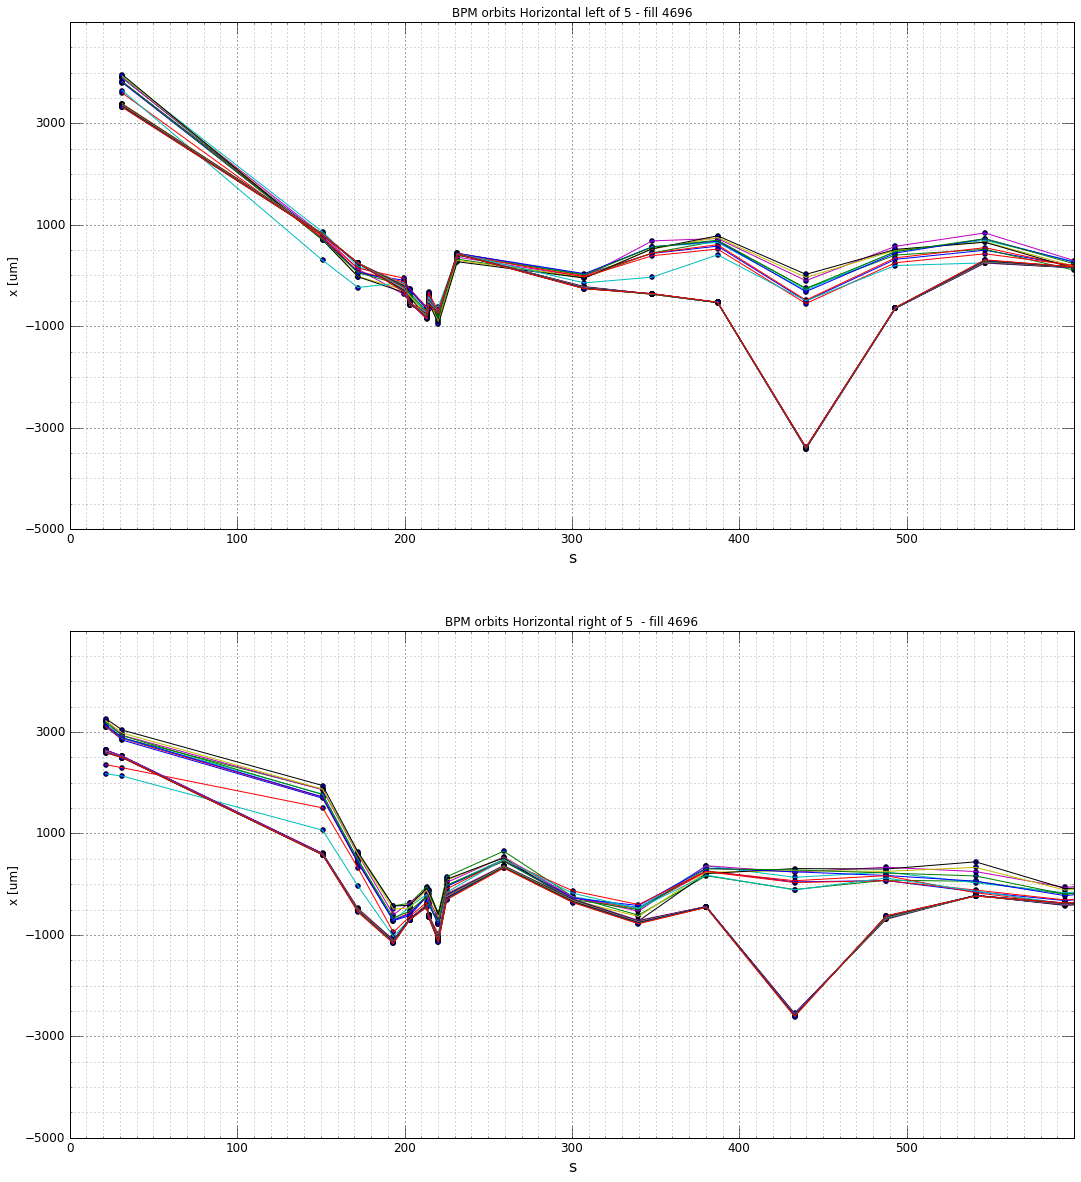

48.0


In [110]:
plotbpm(fill4696,
        '/afs/cern.ch/work/t/tomerten/HI2015/LHCTwiss-LHCB1.tfs',
        '/afs/cern.ch/work/t/tomerten/HI2015/lhcb2-twiss-noerr.tfs',
        ipnr=5,nn=120,step=5)

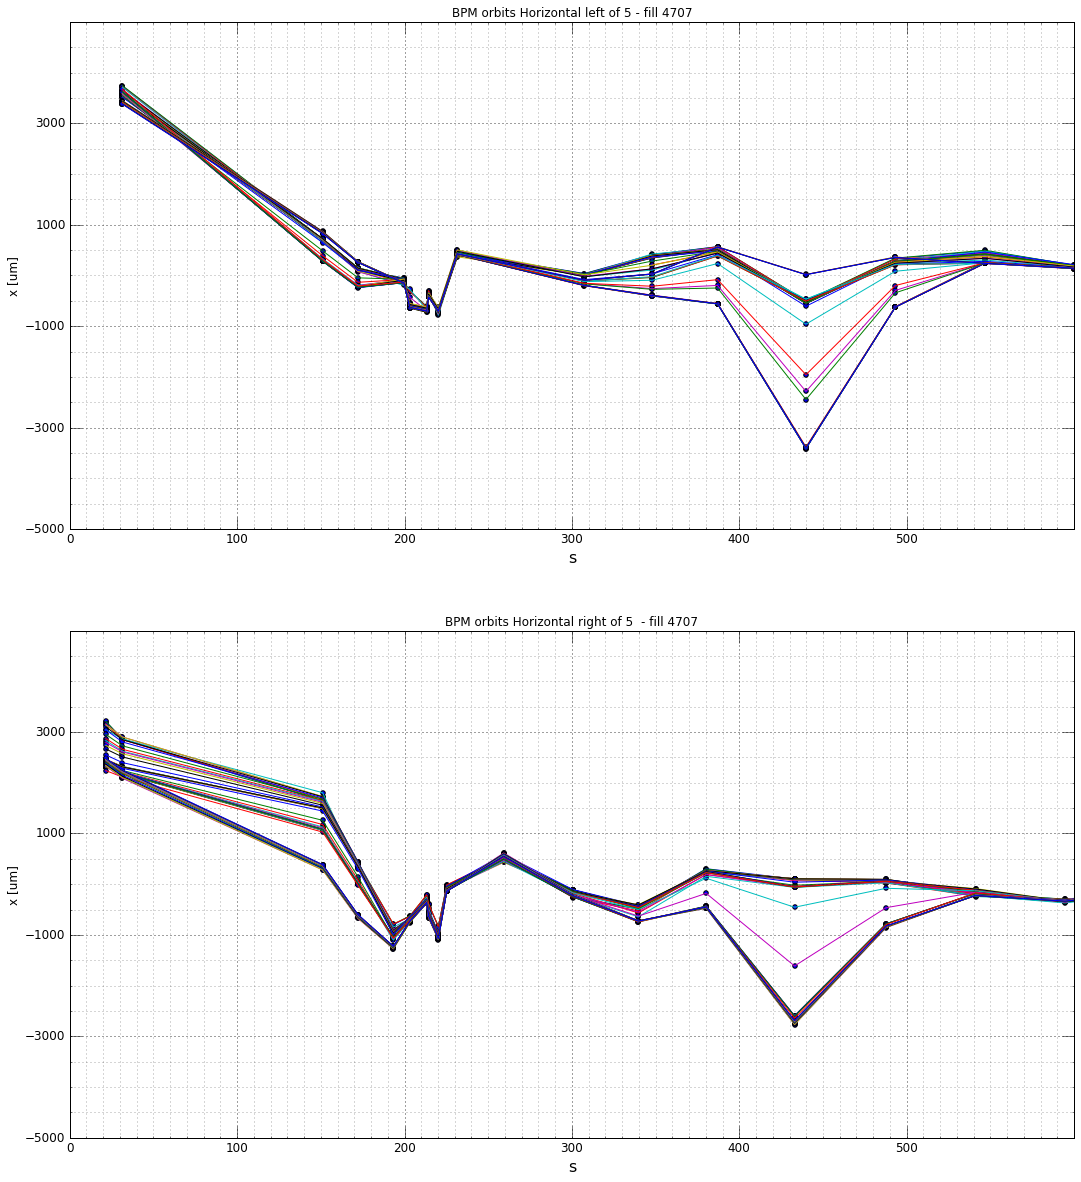

100.0


In [113]:
plotbpm(fill4707,
        '/afs/cern.ch/work/t/tomerten/HI2015/LHCTwiss-LHCB1.tfs',
        '/afs/cern.ch/work/t/tomerten/HI2015/lhcb2-twiss-noerr.tfs',
        ipnr=5,nn=5000,step=100)

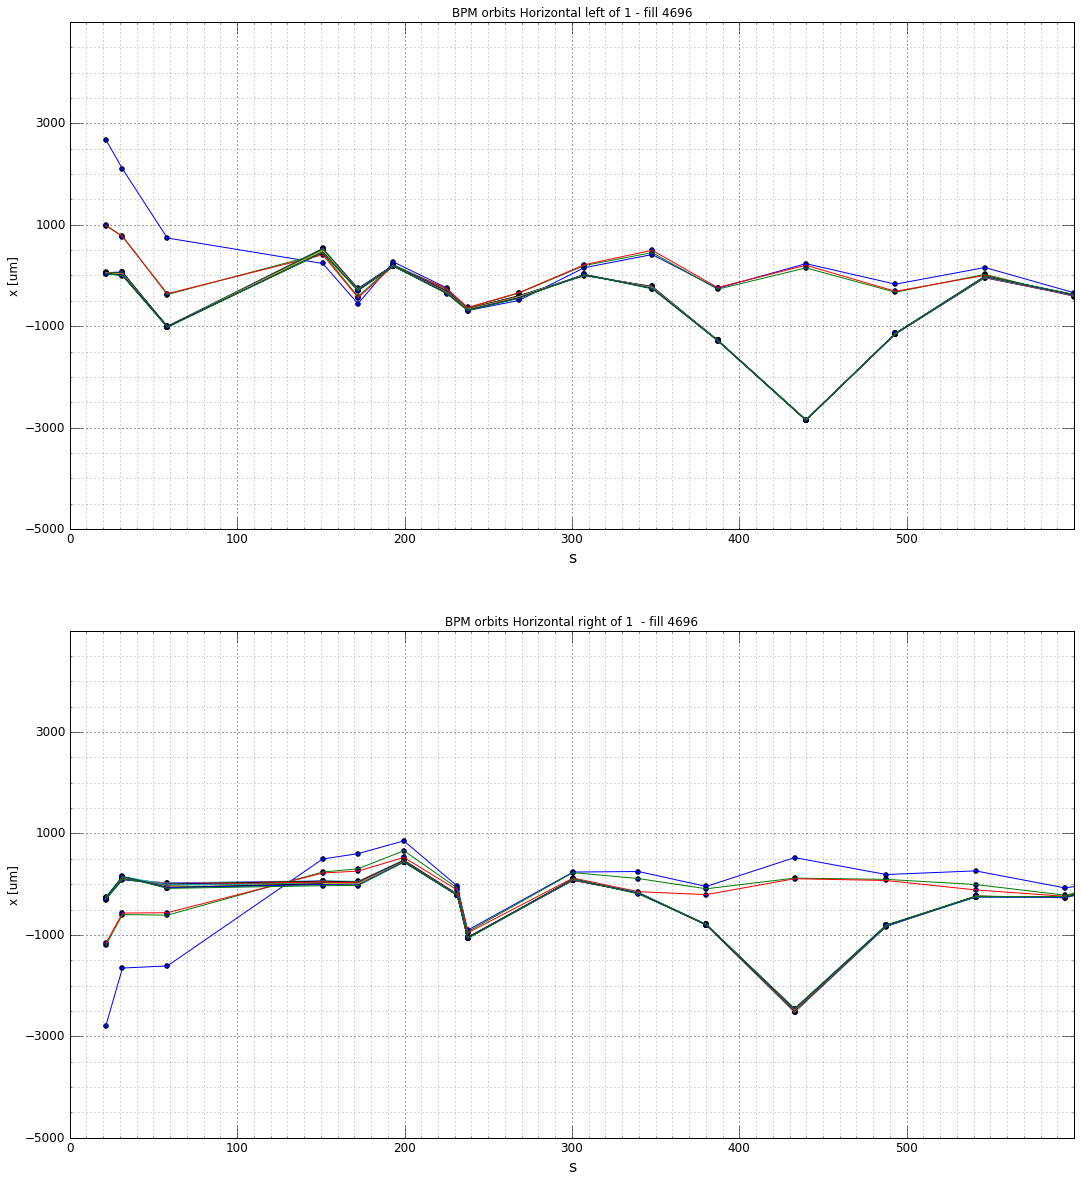

32.0


In [114]:
%matplotlib inline
plotbpm(fill4696,
        '/afs/cern.ch/work/t/tomerten/HI2015/LHCTwiss-LHCB1.tfs',
        '/afs/cern.ch/work/t/tomerten/HI2015/lhcb2-twiss-noerr.tfs',
        ipnr=1,nn=80,step=5)

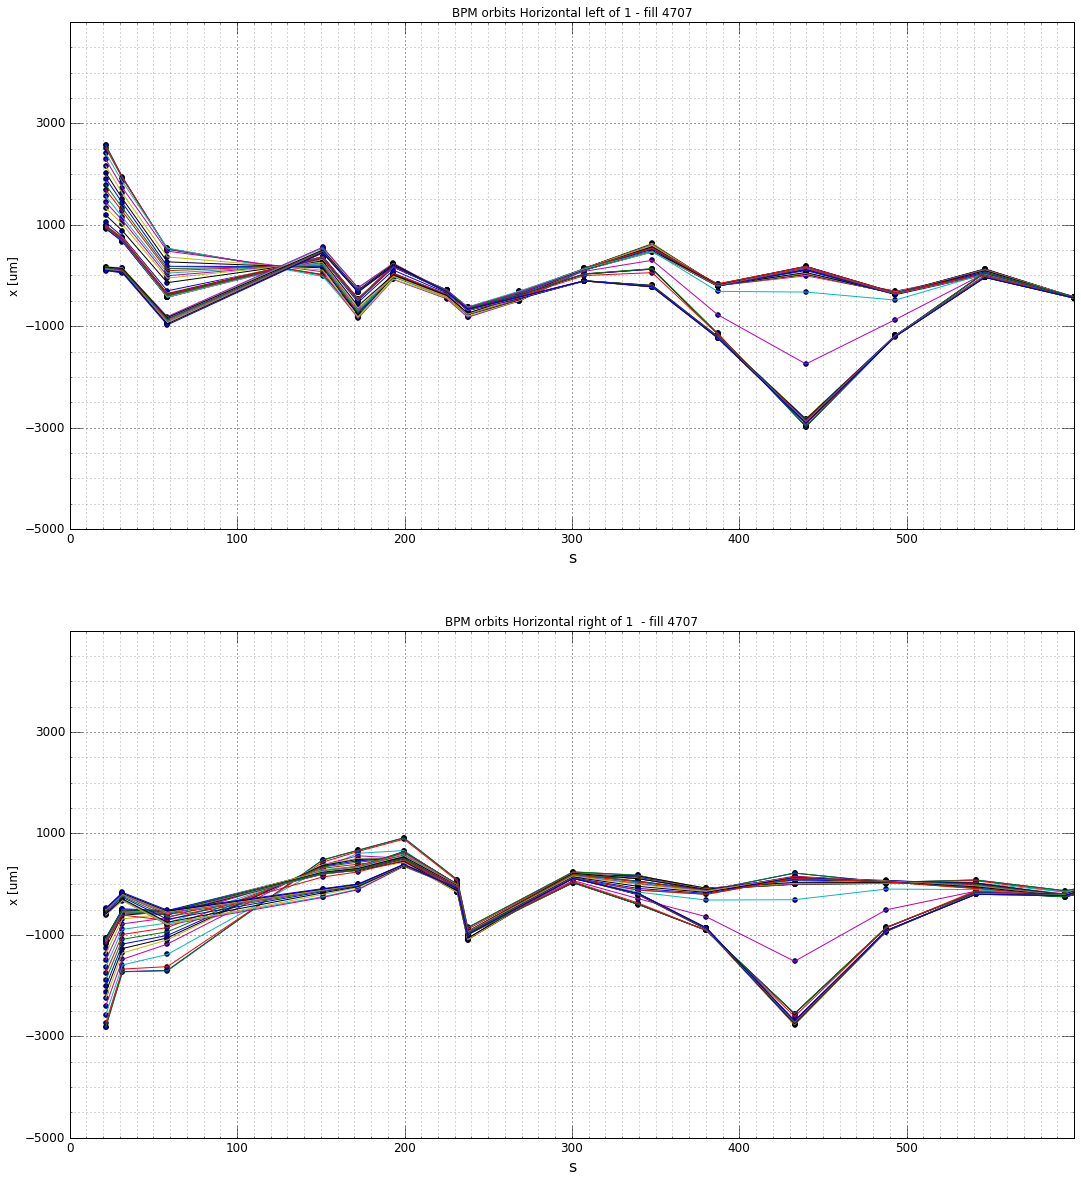

100.0


In [115]:
%matplotlib inline
plotbpm(fill4707,
        '/afs/cern.ch/work/t/tomerten/HI2015/LHCTwiss-LHCB1.tfs',
        '/afs/cern.ch/work/t/tomerten/HI2015/lhcb2-twiss-noerr.tfs',
        ipnr=1,nn=5000,step=100)

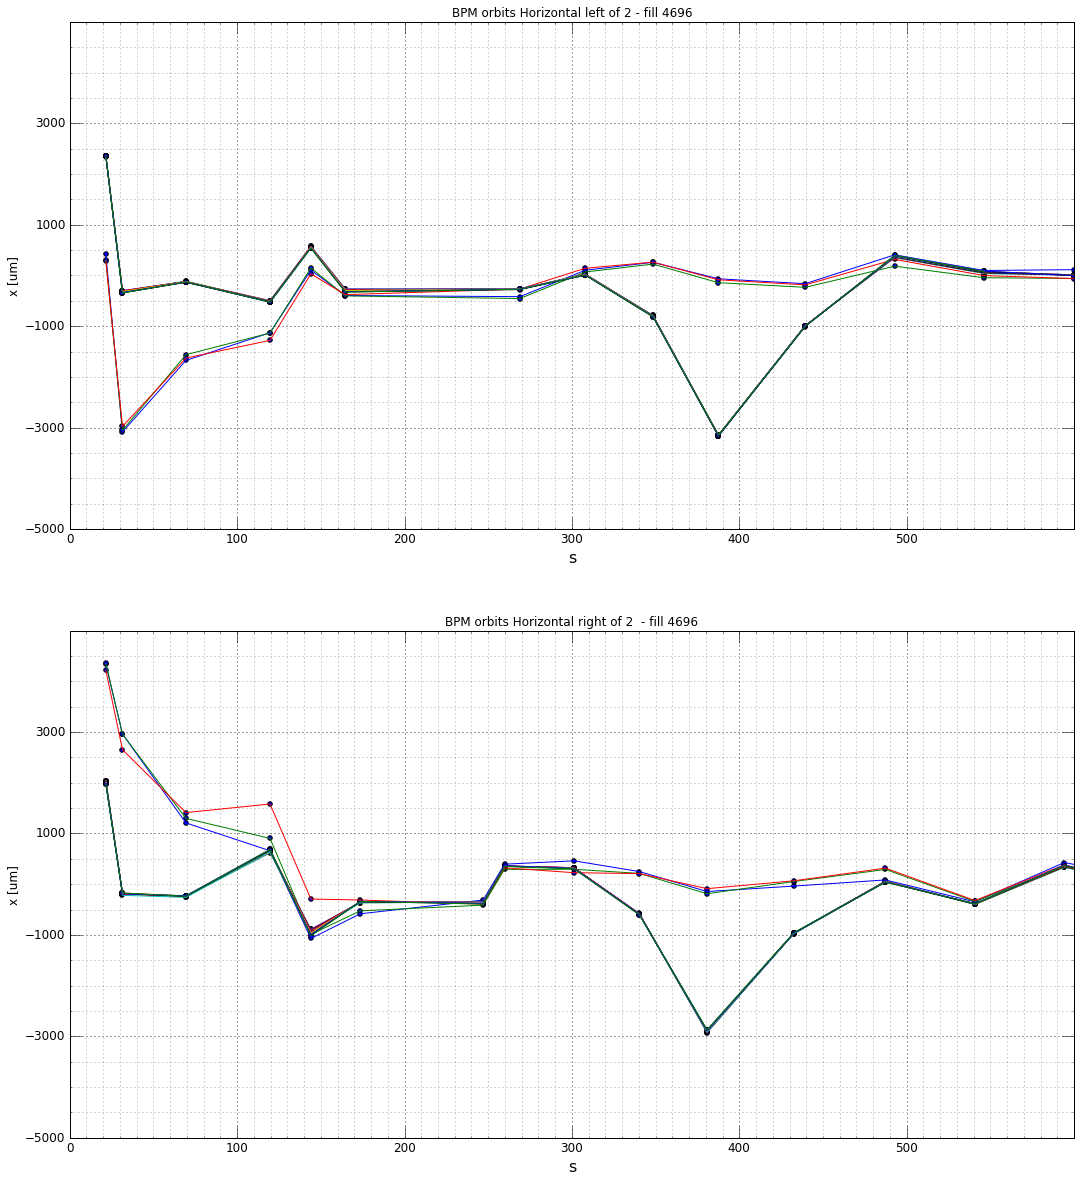

32.0


In [116]:
%matplotlib inline
plotbpm(fill4696,
        '/afs/cern.ch/work/t/tomerten/HI2015/LHCTwiss-LHCB1.tfs',
        '/afs/cern.ch/work/t/tomerten/HI2015/lhcb2-twiss-noerr.tfs',
        ipnr=2,nn=80,step=5)

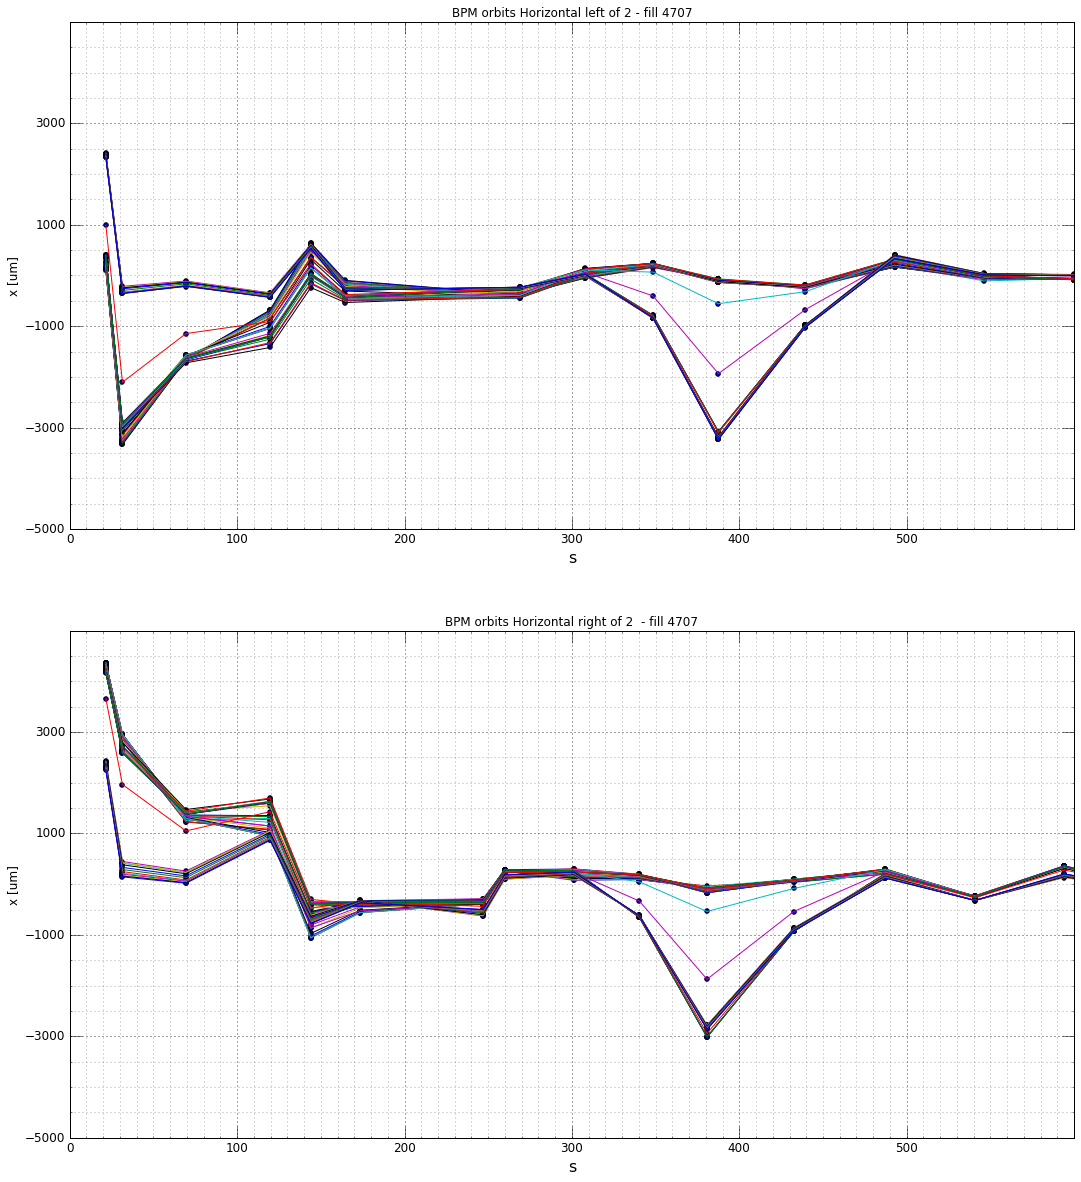

100.0


In [117]:
%matplotlib inline
plotbpm(fill4707,
        '/afs/cern.ch/work/t/tomerten/HI2015/LHCTwiss-LHCB1.tfs',
        '/afs/cern.ch/work/t/tomerten/HI2015/lhcb2-twiss-noerr.tfs',
        ipnr=2,nn=5000,step=100)

# IP1 correlation

In [118]:
bpmltest,namesl,tfsbpml,bpmrtest,namesr,tfsbpmr = fill4707.transformbpmdata(
        '/afs/cern.ch/work/t/tomerten/HI2015/LHCTwiss-LHCB1.tfs',
        '/afs/cern.ch/work/t/tomerten/HI2015/lhcb2-twiss-noerr.tfs',
        ipnr=1)

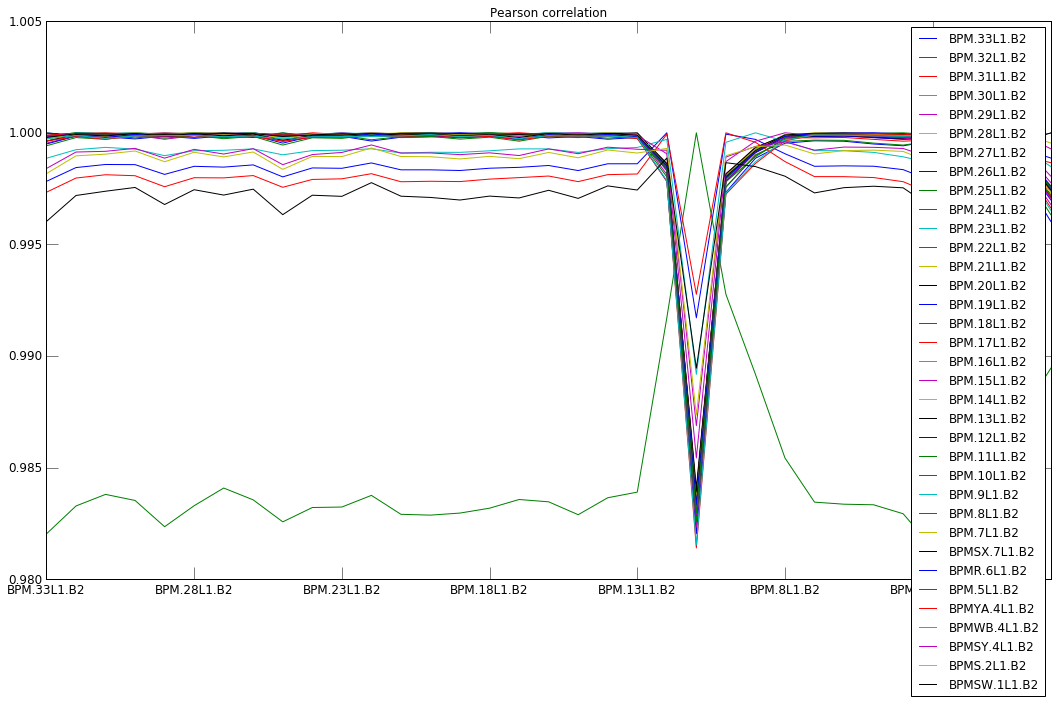

In [124]:
bpmltest.corr(method='pearson').plot(figsize=(18,10),title='Pearson correlation')

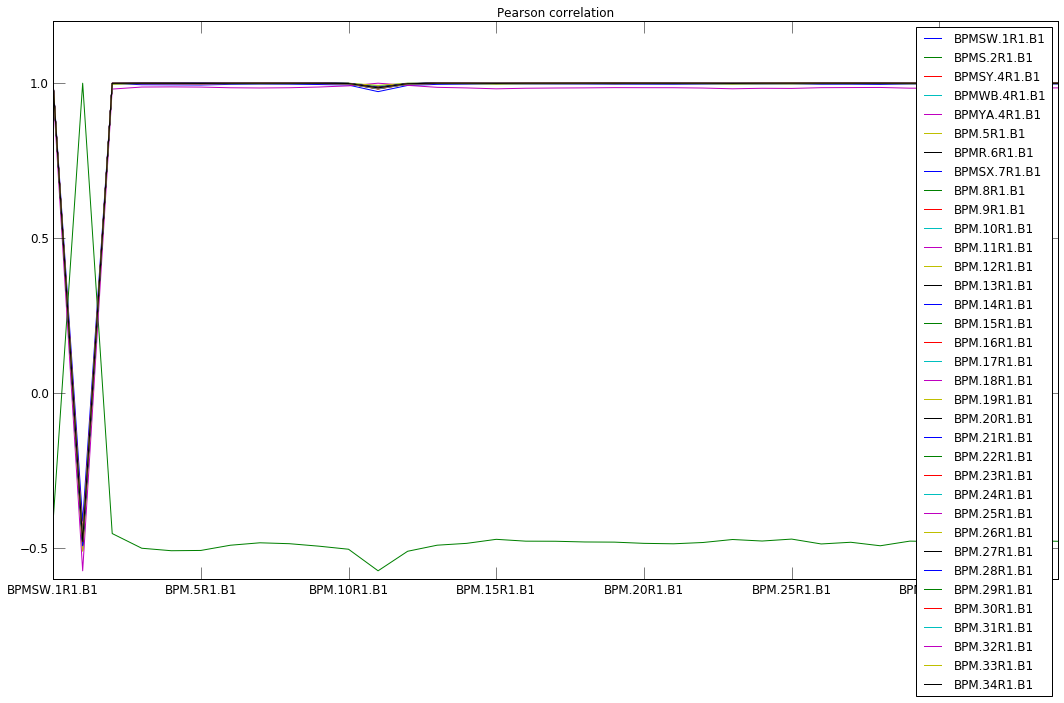

In [125]:
bpmrtest.corr(method='pearson').plot(figsize=(18,10),title='Pearson correlation')

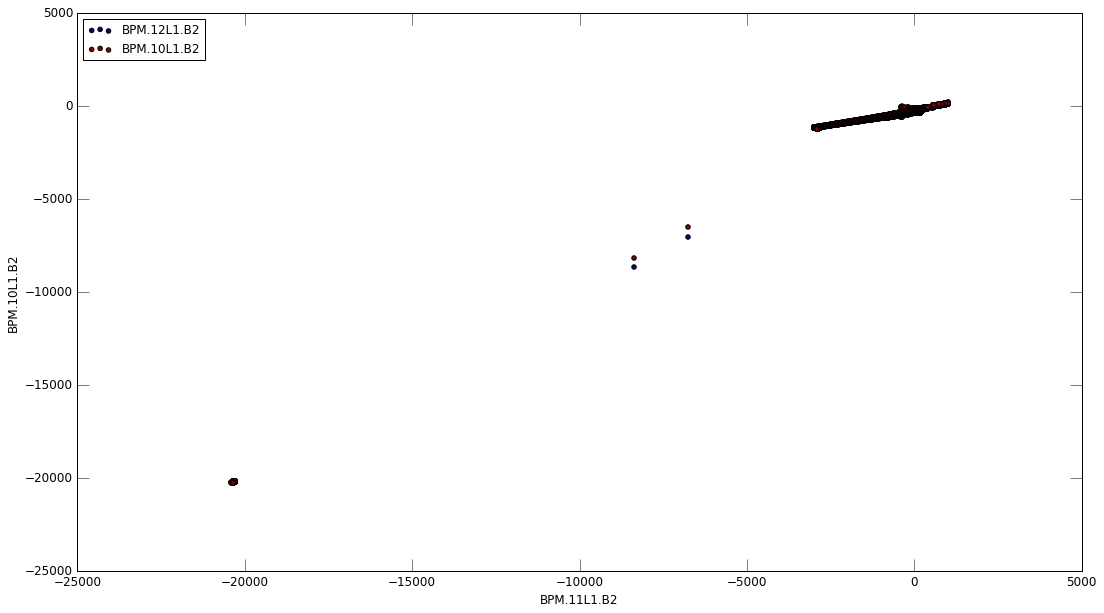

In [134]:
ax = bpmltest.plot.scatter(x='BPM.11L1.B2',y='BPM.12L1.B2',color='DarkBlue',label='BPM.12L1.B2',figsize=(18,10))
bpmltest.plot.scatter(x='BPM.11L1.B2',y='BPM.10L1.B2',color='DarkRed',label='BPM.10L1.B2',ax=ax)
plt.legend(loc=2)

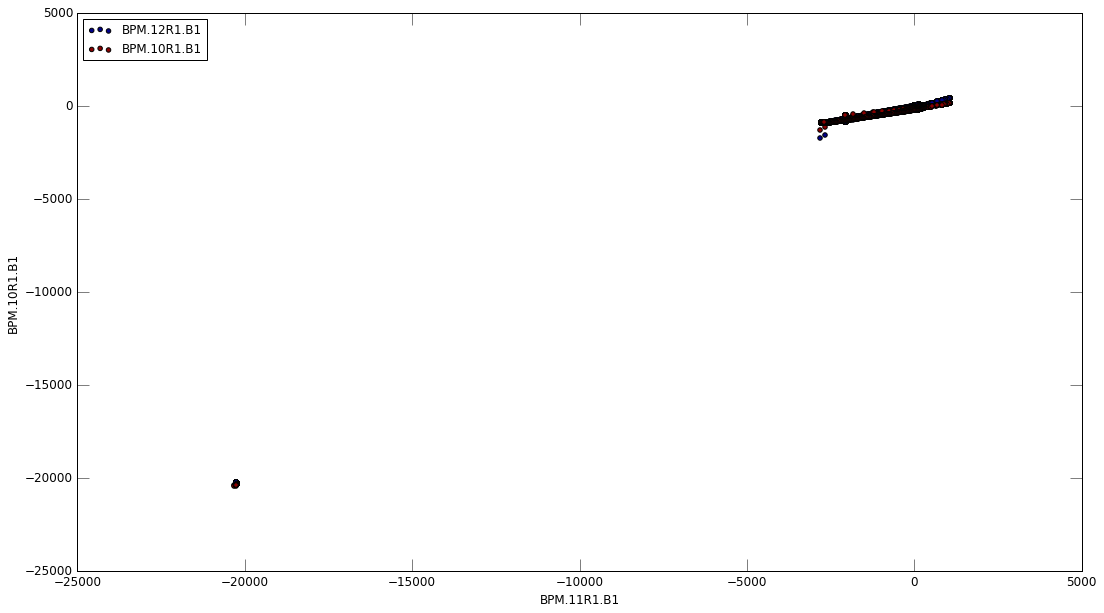

In [135]:
ax = bpmrtest.plot.scatter(x='BPM.11R1.B1',y='BPM.12R1.B1',color='DarkBlue',label='BPM.12R1.B1',figsize=(18,10))
bpmrtest.plot.scatter(x='BPM.11R1.B1',y='BPM.10R1.B1',color='DarkRed',label='BPM.10R1.B1',ax=ax)
plt.legend(loc=2)

# IP5 correlation

In [136]:
bpmltest,namesl,tfsbpml,bpmrtest,namesr,tfsbpmr = fill4707.transformbpmdata(
        '/afs/cern.ch/work/t/tomerten/HI2015/LHCTwiss-LHCB1.tfs',
        '/afs/cern.ch/work/t/tomerten/HI2015/lhcb2-twiss-noerr.tfs',
        ipnr=5)

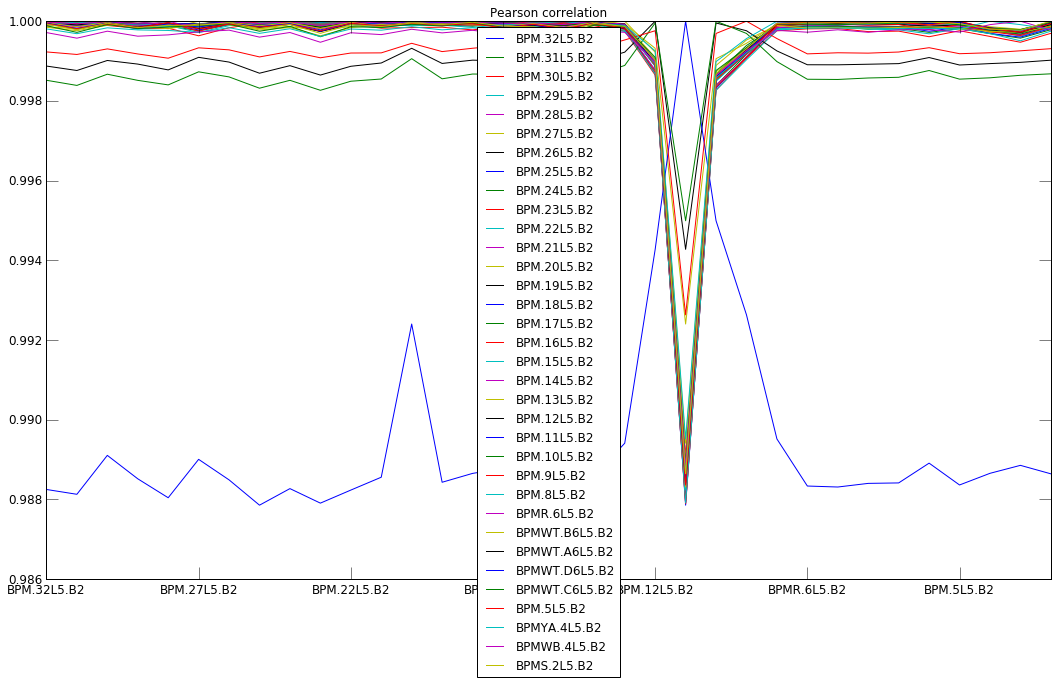

In [137]:
bpmltest.corr(method='pearson').plot(figsize=(18,10),title='Pearson correlation')

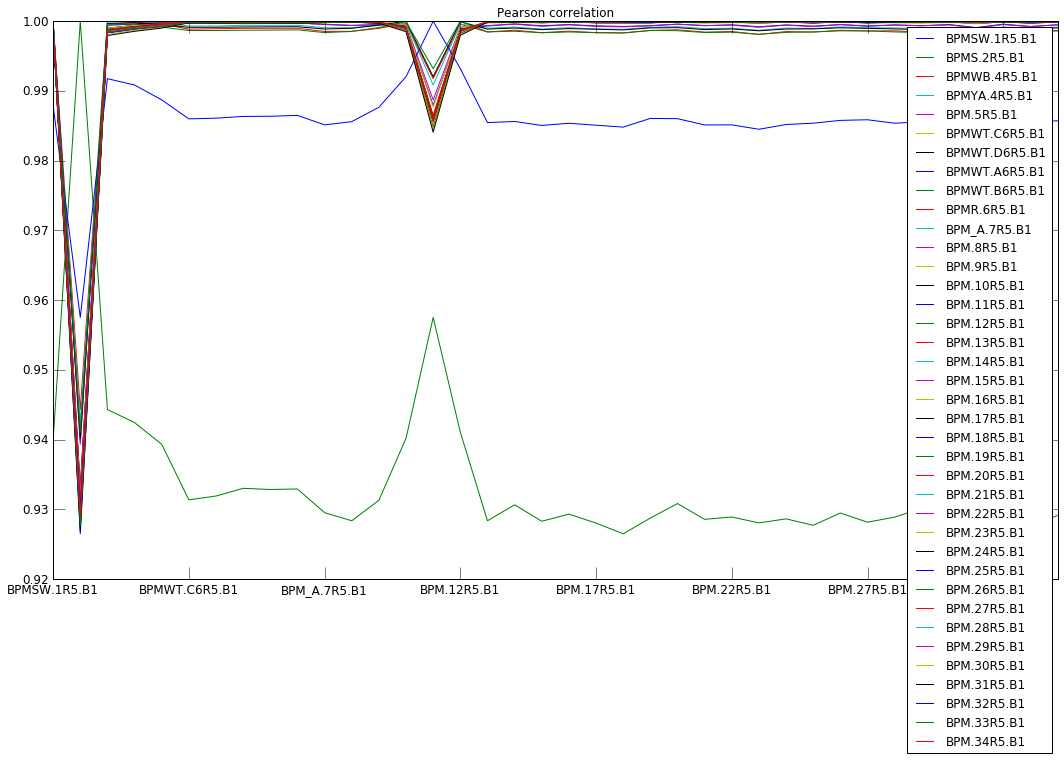

In [138]:
bpmrtest.corr(method='pearson').plot(figsize=(18,10),title='Pearson correlation')

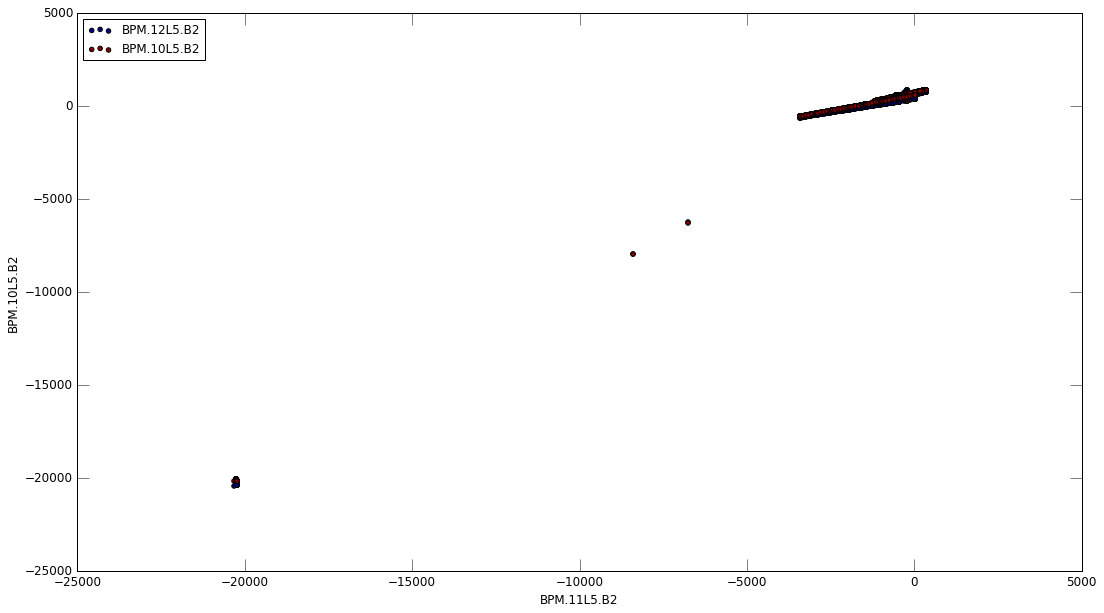

In [139]:
ax = bpmltest.plot.scatter(x='BPM.11L5.B2',y='BPM.12L5.B2',color='DarkBlue',label='BPM.12L5.B2',figsize=(18,10))
bpmltest.plot.scatter(x='BPM.11L5.B2',y='BPM.10L5.B2',color='DarkRed',label='BPM.10L5.B2',ax=ax)
plt.legend(loc=2)

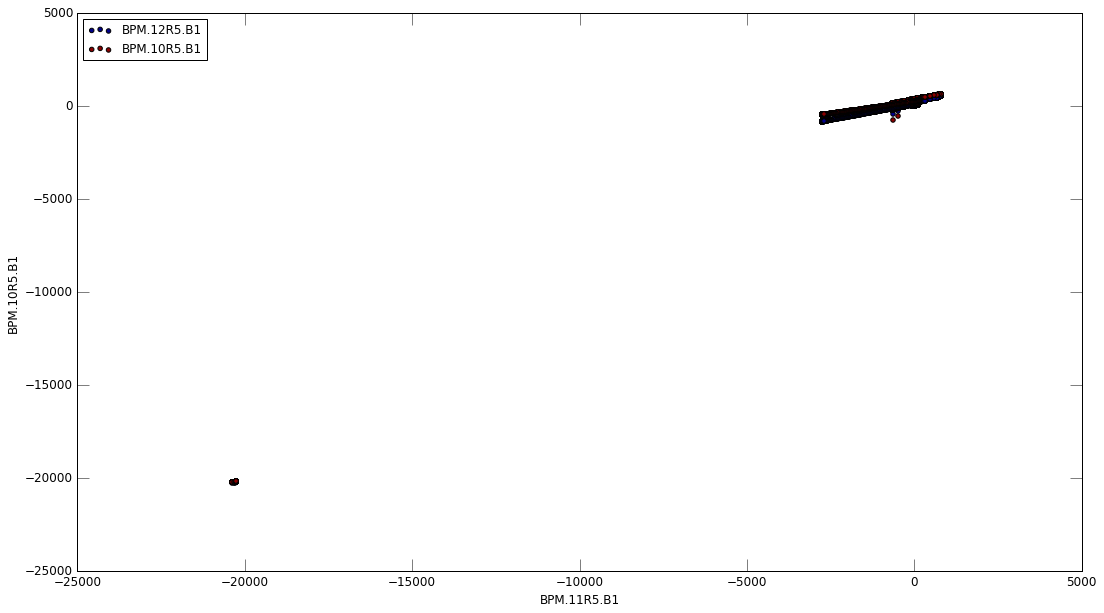

In [142]:
ax = bpmrtest.plot.scatter(x='BPM.11R5.B1',y='BPM.12R5.B1',color='DarkBlue',label='BPM.12R5.B1',figsize=(18,10))
bpmrtest.plot.scatter(x='BPM.11R5.B1',y='BPM.10R5.B1',color='DarkRed',label='BPM.10R5.B1',ax=ax)
plt.legend(loc=2)

2913.33

-524.86000000000001

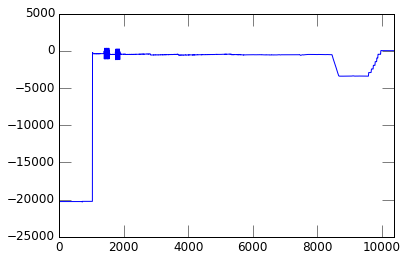

In [196]:
bpmltest['BPM.11L5.B2'].plot()
print bpmltest.loc[[8000]]['BPM.11L5.B2'].values[0]-bpmltest.loc[[9000]]['BPM.11L5.B2'].values[0],
bpmltest.loc[[8000]]['BPM.11L5.B2'].values[0]-bpmltest.loc[[10000]]['BPM.11L5.B2'].values[0]

1027.71


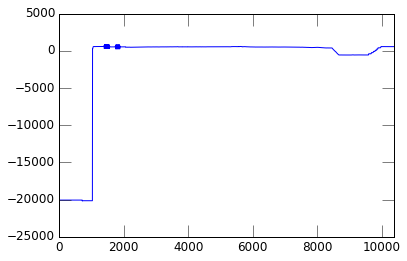

In [194]:
bpmltest['BPM.10L5.B2'].plot()
print bpmltest.loc[[8000]]['BPM.10L5.B2'].values[0]-bpmltest.loc[[9000]]['BPM.10L5.B2'].values[0]

877.95


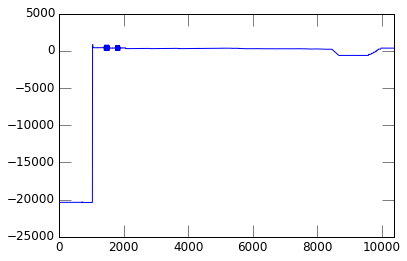

In [198]:
bpmltest['BPM.12L5.B2'].plot()
print bpmltest.loc[[8000]]['BPM.12L5.B2'].values[0]-bpmltest.loc[[9000]]['BPM.12L5.B2'].values[0]

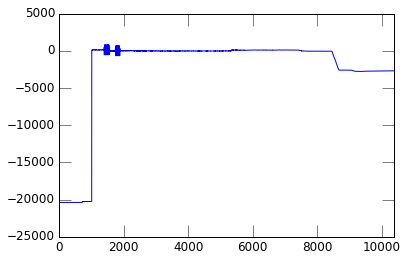

In [188]:
bpmrtest['BPM.11R5.B1'].plot()

In [200]:
bpmrtest.loc[[6000]]['BPM.11R5.B1'].values[0]-bpmrtest.loc[[10000]]['BPM.11R5.B1'].values[0]

2804.3800000000001

It seems the relative differences for the BPM's left and right of BPM.11L5.B2 are consistent with the relative differences from MADX, i.e. for 0 mm bump to 3 mm bump
L10.B2 : delta = 1 mm in MADX and 1.027 from measurement
L12.B2 : delta = 0.8 mm in MADX and 0.878 from measurement
In conclusion, the absolute values are shifted but the relative difference values seem to be ok. This would indicate that the observed discrepancies are probably caused by an inclined beam pipe and asymmetric aperture.

In [197]:
tfsbpml

,NAME,S
7,BPMSW.1L5.B2,21.564
11,BPMWF.A1L5.B2,21.724
18,BPMS.2L5.B2,31.529
44,BPMSY.4L5.B2,58.3145
74,BPMWB.4L5.B2,151.1705
86,BPMYA.4L5.B2,172.229
94,BPM.5L5.B2,199.635
96,BPMWT.C6L5.B2,203.152
106,BPMWT.D6L5.B2,213.225
108,BPMWT.A6L5.B2,214.403
